In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
k_fold = 10
seed = 42
np.random.seed(seed)

In [2]:
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

In [3]:
def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data
def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

#### 1 Read and describe data

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z']
Number of rows: 1470 
Number of columns: 52

Labels: 
label
C    1082
W     388
Name: count, dtype: int64

Missing values: False

Dupli

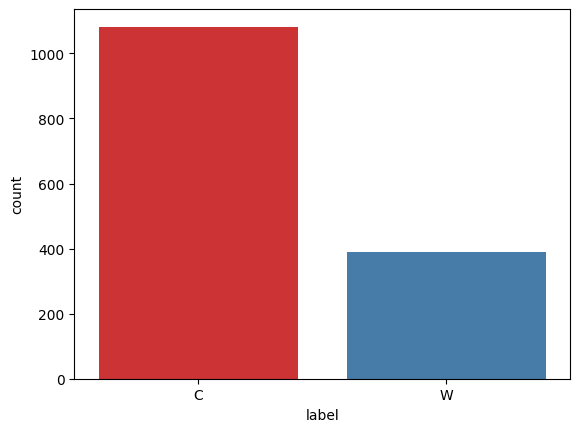

In [4]:
df = describe_dataset('train_clean.csv')
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "C", "label"] = 0
df.loc[df["label"] == "W", "label"] = 1

## Phân chia dữ liệu

### Chia dữ liệu

In [5]:
X = df.drop("label", axis=1)
y = df["label"].astype("int")

In [6]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

### Thử nghiệm các mô hình

In [7]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=repeated_stratify_cv, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.7807256235827664
SVC: 0.808843537414966
KNN: 0.8070294784580498
DTC: 0.754875283446712
SGDC: 0.7494331065759636
NB: 0.7575963718820862
RF: 0.8136054421768708


### Thử nghiệm lại preprocessor

In [8]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list()

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
X = transformed_X
X

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_elbow_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,-1.209163,-0.847997,-0.375651,-1.204186,-0.712234,-1.251459,-1.154677,-1.684040,0.956380,-1.564286,...,-0.642811,1.097095,0.900331,1.306251,1.059839,1.585424,-0.703147,1.027698,1.050769,1.302614
1,-1.153432,-1.354423,-0.572406,-1.089244,-1.371049,-1.296111,-1.111365,-2.221800,0.965790,-1.222859,...,-0.554118,1.165468,0.356148,1.306351,1.259701,1.061248,-0.639030,1.200353,0.588458,1.259262
2,-1.227402,-0.242273,-0.027139,-1.224606,0.067898,-0.964437,-1.195415,-1.417358,0.988459,-0.732209,...,-0.801934,1.256149,-0.839384,0.716163,1.376131,-0.266602,-0.772569,1.368703,-0.564497,0.683720
3,-1.266718,0.984939,0.451295,-1.250297,1.731556,-0.851963,-1.236652,-0.019817,1.159952,-0.712943,...,-0.972125,1.259410,-1.517899,0.593263,1.397250,-1.035804,-0.954646,1.395602,-1.295618,0.505439
4,-1.275372,0.796854,0.841109,-1.258138,1.778913,-0.826775,-1.252611,0.005374,1.311218,-0.742407,...,-1.321770,1.259084,-1.276433,0.353206,1.301175,-0.668764,-1.341771,1.300157,-0.975962,0.294426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.984371,0.814086,-0.051641,1.050341,0.896658,0.747016,0.982953,1.014131,-0.953561,1.445274,...,0.793661,-0.742737,1.770972,-0.402460,-0.680722,1.514659,0.800590,-0.637449,1.530891,-0.421835
1466,0.959012,-0.355524,-0.592942,0.936442,-0.177910,0.599880,0.915266,-0.002742,-0.940436,1.227308,...,0.920815,-0.824818,0.934428,-0.435198,-0.395556,0.797263,1.157208,-0.794838,0.999865,-0.352951
1467,0.859666,-0.942147,-4.459192,0.941422,-0.257718,0.061047,0.780280,-0.408040,-1.554938,1.220907,...,1.374617,-0.615086,1.388110,0.641680,-0.344383,0.860217,1.559337,-0.753461,1.028890,0.597934
1468,0.573880,-3.064507,-5.141989,0.778272,-1.476930,-0.338027,0.293086,-3.356120,-1.568847,0.985292,...,0.078611,-0.436058,1.426922,1.025361,-0.281234,1.188661,0.128774,-0.474739,1.145785,1.071084


# Chọn bộ tham số

#### Dùng GridSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

In [ ]:
best_params_grid = {}
models_tuned_grid = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ("SVC", SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    },
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}

# Grid Search application with check for parameter grid existence
for name, model in models.items():
    print("Model processing: ", name)
    if name in param_grid:
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid[name], 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,  # Sử dụng tất cả các lõi CPU để tăng tốc quá trình
            verbose=1  # Hiển thị tiến trình trong quá trình tìm kiếm
        )
        grid_search.fit(X_train, y_train)
        best_params_grid[name] = grid_search.best_params_
        models_tuned_grid[name] = grid_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params1.json', 'w') as f:
    json.dump(best_params_grid, f)

In [ ]:
# Printing the best parameters for each model
print("Best parameters for each model:")
for name, params in best_params_grid.items():
    print(f"{name}: {params}")

# Printing the tuned models
print("\nTuned models:")
for name, model in models_tuned_grid.items():
    print(f"{name}: {model}")


#### Dùng RandomizedSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

##### SVC

In [ ]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

##### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


##### Các thuật toán khác

In [ ]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


#### Thử nghiệm bộ tham số

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(**best_params.get("SGDC", {})))),
    ("NB", GaussianNB()),  # GaussianNB không có tham số cụ thể để điều chỉnh
    ('RF', RandomForestClassifier(**best_params.get("RF", {}), random_state=42)),
]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    a_score = accuracy_score(y_test, model_results)
    final_results.append((name, a_score))

# Sort results by accuracy score
final_results.sort(key=lambda k: k[1], reverse=True)

pd.DataFrame(final_results, columns=["Model", "Accuracy score"])


,Model,Accuracy score
0,KNN,0.809524
1,LR,0.802721
2,SVC,0.799320
3,RF,0.795918
4,SGDC,0.792517
5,DTC,0.772109
6,NB,0.758503


##### SVC

In [13]:
with open('best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
svc_model = SVC(probability=True, **best_params.get("SVC", {}), random_state=42)
svc_model.fit(X_train, y_train)

# Lưu mô hình vào file
with open('best_models/SVC_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

##### Random forest

In [1]:
with open('best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)
rf_model.fit(X_train, y_train)

# Lưu mô hình vào file
with open('best_models/RF_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

NameError: name 'json' is not defined

#### Các thuật toán khác: LR, KNN, DTC

In [22]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

LR: 0.849428463760834
KNN: 0.8212319146749494
DTC: 0.8207271813728291


#### Dự đoán thử nghiệm

In [88]:
def load_model(model_filename):
    with open(model_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

# Example of loading the Logistic Regression model
loaded_lr_model = load_model('best_models/SVC_model_side.pkl')

In [89]:
predictions = loaded_lr_model.predict(X_test)
predictions

array([1, 2, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 2, 1, 0, 0,
       1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1, 1, 2,
       1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1,
       1, 2, 1, 0, 1, 2, 2, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 0, 1, 2, 2, 2, 1, 2, 0, 2,
       1, 0, 1, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2,
       1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0,
       0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1,
       2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1, 2, 2,

In [90]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Optionally, add a column to check if the predictions match the actual values
comparison_df['Match'] = comparison_df['Actual'] == comparison_df['Predicted']

# Display the DataFrame
print(comparison_df)

      Actual  Predicted  Match
1280       1          1   True
29         2          2   True
210        2          2   True
1730       0          0   True
584        2          2   True
...      ...        ...    ...
1894       0          1  False
1080       1          1   True
962        1          1   True
1606       1          0  False
1285       1          1   True

[419 rows x 3 columns]


In [91]:
# Calculate the percentage of matches
match_rate = comparison_df['Match'].mean() * 100
print(f"Percentage of Correct Predictions: {match_rate:.2f}%")


Percentage of Correct Predictions: 91.89%
